   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 24.0 MB/s eta 0:00:00
Querying Gaia DR3 for high-parallax stars...
Attempt 1 of 3...


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Column names: ['DESIGNATION', 'parallax', 'ra', 'dec', 'teff_gspphot', 'non_single_star']
Records removed due to missing data: 1466

Summary of Retrieved Stars:
------------------------------
Total stars retrieved: 1160
Closest star (shortest distance): 4.246 light years
Farthest star (longest distance): 65.165 light years
Temperature range: 2809K - 7938K
Standard deviation of temperature: 985.83K

Stars by Stellar Class:
stellar_class
A      1
F     47
G    102
K    206
M    804
Name: count, dtype: int64


<ipython-input-1-4d7846ecb9cf>:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='stellar_class', palette=class_palette)


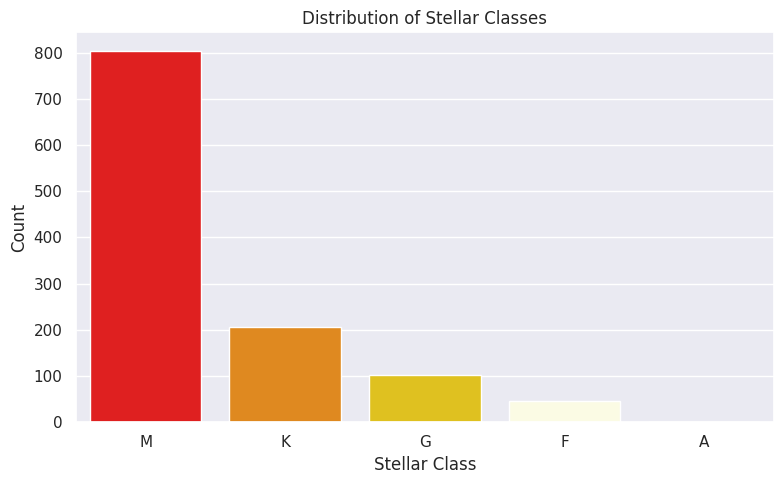

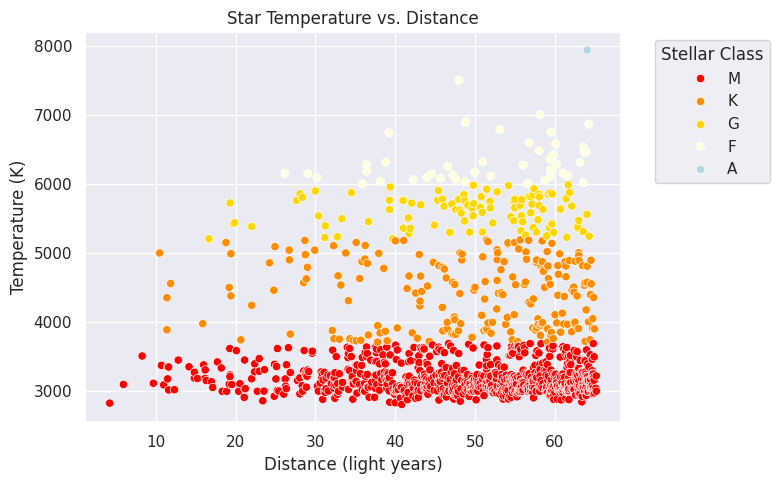

<ipython-input-1-4d7846ecb9cf>:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='stellar_class', y='teff_gspphot', palette=class_palette,


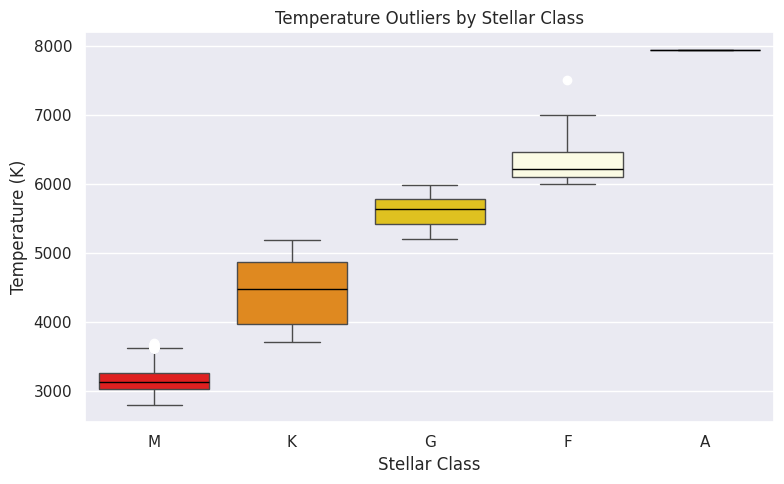

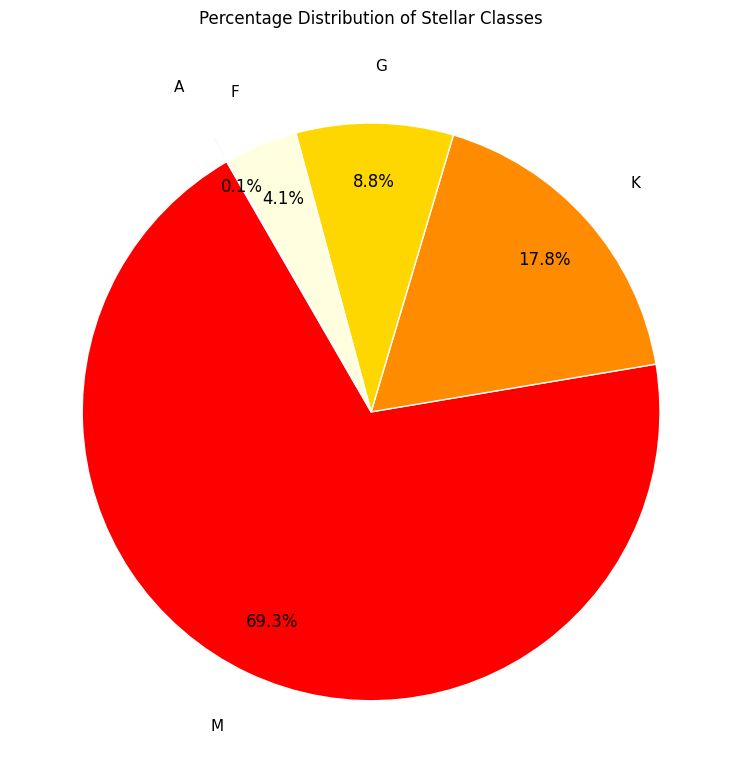

Results saved to high_parallax_stars.csv
Results saved to SQLite database: star_data.db


In [ ]:
!pip install astroquery

from astroquery.gaia import Gaia
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import time

def get_stellar_class(temperature):
    """
    Determine stellar class based on temperature ranges.
    """
    if pd.isna(temperature):
        return 'Unknown'
    elif temperature > 30000:
        return 'O'
    elif temperature >= 10000:
        return 'B'
    elif temperature >= 7500:
        return 'A'
    elif temperature >= 6000:
        return 'F'
    elif temperature >= 5200:
        return 'G'
    elif temperature >= 3700:
        return 'K'
    else:
        return 'M'

def convert_parallax_to_lightyears(parallax):
    """
    Convert parallax (in milliarcseconds) to distance in light years.
    """
    if pd.isna(parallax) or parallax <= 0:
        return None
    parsecs = 1000 / parallax  # Convert milliarcseconds to parsecs
    lightyears = parsecs * 3.26156  # Convert parsecs to light years
    return lightyears

def query_nearby_star_data():
    """
    Query Gaia DR3 for stars with high parallax (close to Earth) and additional attributes.
    """
    query = """
    SELECT
        designation,
        parallax,
        ra,
        dec,
        teff_gspphot,
        non_single_star
    FROM gaiadr3.gaia_source
    WHERE parallax > 50  -- Select stars relatively close to Earth
        AND parallax_over_error > 5  -- Ensure data quality
    ORDER BY parallax DESC
    """

    max_attempts = 3
    attempt = 0

    while attempt < max_attempts:
        try:
            print(f"Attempt {attempt + 1} of {max_attempts}...")
            job = Gaia.launch_job_async(query)
            results = job.get_results()

            # Convert results to pandas DataFrame
            df = results.to_pandas()

            # Profile data: Check column names
            print("Column names:", df.columns.tolist())

            # Standardize column names to lowercase
            df.columns = df.columns.str.lower()

            # Add stellar classification based on temperature
            df['stellar_class'] = df['teff_gspphot'].apply(get_stellar_class)

            # Convert parallax to light years
            df['distance_ly'] = df['parallax'].apply(convert_parallax_to_lightyears)

            # Handle missing data
            missing_before = len(df)
            df = df.dropna(subset=['parallax', 'teff_gspphot', 'distance_ly'])
            missing_after = len(df)
            print(f"Records removed due to missing data: {missing_before - missing_after}")

            # Remove unnecessary columns
            columns_to_drop = ['non_single_star']
            df = df.drop(columns=columns_to_drop, errors='ignore')

            # Round off relevant columns for better readability
            df = df.round({'parallax': 3, 'teff_gspphot': 0, 'ra': 3, 'dec': 3, 'distance_ly': 3})

            return df

        except Exception as e:
            print(f"Error occurred: {str(e)}")
            attempt += 1
            if attempt < max_attempts:
                print("Waiting 5 seconds before retrying...")
                time.sleep(5)
            else:
                print("Max attempts reached. Query failed.")
                raise

    return None

def save_results_to_csv(df, output_file='high_parallax_stars.csv'):
    """
    Save results to a CSV file.
    """
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

def save_results_to_db(df, db_name='star_data.db'):
    """
    Save results to an SQLite database.
    """
    conn = sqlite3.connect(db_name)
    df.to_sql('stars', conn, if_exists='replace', index=False)
    conn.close()
    print(f"Results saved to SQLite database: {db_name}")

def print_summary(df):
    """
    Print a summary of the retrieved star data.
    """
    print("\nSummary of Retrieved Stars:")
    print("-" * 30)
    print(f"Total stars retrieved: {len(df)}")
    print(f"Closest star (shortest distance): {df['distance_ly'].min():.3f} light years")
    print(f"Farthest star (longest distance): {df['distance_ly'].max():.3f} light years")

    # Temperature range
    temp_stats = df['teff_gspphot'].dropna()
    if not temp_stats.empty:
        print(f"Temperature range: {temp_stats.min():.0f}K - {temp_stats.max():.0f}K")
        print(f"Standard deviation of temperature: {temp_stats.std():.2f}K")

    print("\nStars by Stellar Class:")
    print(df['stellar_class'].value_counts().sort_index())

def visualize_data(df):
    """
    Create visualizations for the star data.
    """
    sns.set_theme(style="darkgrid")

    # Define a custom color palette matching stellar classes
    class_palette = {
        'O': '#0000FF',  # Blue
        'B': '#4682B4',  # Blue-White
        'A': '#ADD8E6',  # White
        'F': '#FFFFE0',  # Yellow-White
        'G': '#FFD700',  # Yellow
        'K': '#FF8C00',  # Orange
        'M': '#FF0000',  # Red
        'Unknown': '#A9A9A9'  # Gray for unknown
    }

    # Filter out 'Unknown' for temperature-based plots
    df_filtered = df[df['stellar_class'] != 'Unknown']

    # Histogram of Stellar Classes
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='stellar_class', palette=class_palette)
    plt.title('Distribution of Stellar Classes')
    plt.xlabel('Stellar Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Scatter Plot of Distance vs. Temperature
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_filtered, x='distance_ly', y='teff_gspphot', hue='stellar_class', palette=class_palette)
    plt.title('Star Temperature vs. Distance')
    plt.xlabel('Distance (light years)')
    plt.ylabel('Temperature (K)')
    plt.legend(title='Stellar Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Boxplot for Outliers in Temperature by Stellar Class
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_filtered, x='stellar_class', y='teff_gspphot', palette=class_palette,
                flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'white', 'markersize': 6},
                medianprops={'color': 'black'})
    plt.title('Temperature Outliers by Stellar Class')
    plt.xlabel('Stellar Class')
    plt.ylabel('Temperature (K)')
    plt.tight_layout()
    plt.show()

# Pie Chart for Stellar Class Distribution
    class_counts = df['stellar_class'].value_counts()
    explode = [0.1 if value < 5 else 0 for value in class_counts]  # Explode smaller segments
    plt.figure(figsize=(8, 8))
    plt.pie(
        class_counts,
        labels=class_counts.index,
        autopct='%1.1f%%',
        colors=[class_palette[key] for key in class_counts.index],
        startangle=120,  # Rotate to adjust positions
        textprops={'color': 'black'},
        labeldistance=1.2,  # Move labels further out
        pctdistance=0.8,  # Adjust percentage placement
        explode=explode  # Highlight smaller segments
    )
    plt.title('Percentage Distribution of Stellar Classes', color='black', pad=20)  # Adjust padding
    plt.tight_layout()
    plt.show()





def main():
    try:
        print("Querying Gaia DR3 for high-parallax stars...")
        df = query_nearby_star_data()

        if df is not None and not df.empty:
            print_summary(df)
            visualize_data(df)
            save_results_to_csv(df)
            save_results_to_db(df)
        else:
            print("No data retrieved from the query.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()